# EXPLORING PLACES IN VIJAYAWADA,ANDHRA PRADESH,INDIA

## INTRODUCTION

The aim of the project is to identify places in Vijayawada, India based on their ratings and average prices. In this notebook, we will identify various venues in the city of Vijayawada using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.Whenever a user is visiting any city they eventually start looking for places to visit during their stay. They primarily look for places based on the ratings and the average prices everyone does this.Here, we will try to identify places for various individuals based on the information collected from the APIs and applying Data Science.The reason of choosing this as my project is living in this city from many years I still don't know some places that are really good here and many face the same thing. Maybe this research will solve the problem.

## DATA COLLECTION

We will initially take a look at the city vijayawada on the Map using the folium library using the latitude and longitude.
We will also get the required data from the specified APIs.
Foursquare API: We will use the Foursquare API to fetch venues in Vijayawada starting from the middle upto 30 Kilometers in each direction.
Zomato API: This provides information about various venues including the detailed address, user given ratings, price range and more.

### VIJAYAWADA

Vijayawada is composed of a number of sectors spread across a total area of 61.88 sq Km. 
There are many venues (especially restaurants, hotels and cafes) which everyone wants to know.

First we will locate Vijayawada on the map using latitudes and logitudes

In [1]:
VJA_LATITUDE = '16.5062'
VJA_LONGITUDE = '80.6480'
print('The coordinates of Vijayawada are {}, {}.'.format(VJA_LATITUDE, VJA_LONGITUDE))

The coordinates of Vijayawada are 16.5062, 80.6480.


Now let's plot vijayawada on the map using folium library

In [2]:
!pip install folium
import pandas as pd
import folium

In [3]:
import folium
vja_map = folium.Map(location = [VJA_LATITUDE, VJA_LONGITUDE], zoom_start = 10)
folium.Marker([VJA_LATITUDE,VJA_LONGITUDE]).add_to(vja_map)
vja_map

## Using foursquare API

We begin by fetching a total of all venues in Vijayawada upto a range of 2 Kilometers using the Foursquare API. 
The Foursquare API has an attribute explore API which allows us to find places recommendations within a given radius from the given coordinates. 

In [4]:
FOURSQUARE_CLIENT_ID = 'PLZNCKKKLM41EKE10AB45JLOQYBUHWJP5SVWWJL0A2O3C5NP'
FOURSQUARE_CLIENT_SECRET = 'E2SXYPU4HYMHSSSGTILSC145BN00GCJMHY4IL3PNOLJM4QHQ'
RADIUS = 2000
NO_OF_VENUES = 10
VERSION = '20200505' # Current date

Getting categories for each place

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We will call the API over and over till we get all the places from the API within the given distance. The maximum places this API can fetch is 100, so we will fetch all the places required by iteratively calling this API and increasing the offset each time.
Foursquare API requires client_id, and client_secret to function which can be accessed only after creating a developer account.
We will set the radius as 5 Kilometers to fetch the places within the bound.
The version is a important required parameter which defines the present date so that it retrieves the latest data.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
import requests
pd.set_option('display.max_rows', None)

In [7]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])
while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        VJA_LATITUDE, 
                                                                        VJA_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))
    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    #  Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 10 venues fetched within a total radius of 2.0 Km

Total 10 venues fetched


## Zomato api

In [8]:
headers = {'user-key': 'b214bbab9e6f8d69683204cca30ec978'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}'+'&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10


## DATA CLEANING

It is always important to sort the data available/retrieved from various sources and combine them.
We will first plot the two data points on the map. We will then try to combine data points that having their latitude and longitude values close to one another. From the remaining places that are selected, we will inspect the available places to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin analysis.
We will first plot the Foursquare API

In [9]:
vja_map = folium.Map(location = [VJA_LATITUDE, VJA_LONGITUDE], zoom_start = 10)
for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(vja_map)  
vja_map

plot zomato API

In [10]:
vja_map = folium.Map(location = [VJA_LATITUDE, VJA_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(vja_map)  
vja_map

To combine the datasets,we must check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values by upto 4 decimal places. Then, I will calculate the difference between the corresponding latitude and longitude values and to see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [11]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [12]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [13]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Baskin-Robbins,Ice Cream Shop,16.5032,80.6483,Baskin Robbins,16.5033,80.6481,200,1,3.4,"40-5-19/2, Tille Road, Labbipet, Vijayawada",0.0001,-0.0002
1,Kitkat,Bakery,16.5011,80.6577,Kitkat,16.5008,80.6577,400,2,3.6,"K.P Nagar, Chandralok Complex, Beside TVS Show...",-0.0003,0.0000
2,Life Style LEPL,Clothing Store,16.5004,80.6459,Barbeque Nation,16.5003,80.6458,1400,3,4.8,"3rd Floor, LEPL Centro Mall, M.G.Road, Labbipe...",-0.0001,-0.0001
3,PVP Square,Shopping Mall,16.5025,80.6427,Keventers - The Original Milkshake,16.5024,80.6426,400,2,3.0,"39-1-57, Third Floor, PVP Square Mall, MG Road...",-0.0001,-0.0001
4,Subway,Fast Food Restaurant,16.5041,80.6470,Subway,16.5044,80.6471,500,2,4.0,"40-6-22/1A, Labbipet, Vijayawada",0.0003,0.0001
5,Cream Stone,Ice Cream Shop,16.5039,80.6366,Cream Stone,16.5039,80.6365,300,1,4.2,"Vijayawada, Punammathota, Labbipet, Vijayawada",0.0000,-0.0001
6,Minerva Grand Restaurant.,Restaurant,16.5023,80.6431,Blue Fox,16.5022,80.6432,600,2,3.9,"Minerva Grand, Near PVP Square Mall, M.G Road,...",-0.0001,0.0001


Drop the places with 0 rating if there are any

In [14]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 7


## METHODOLOGY

This project aims at identifying the places in Vijayawada based on their rating and average costs.
This would enable any visitor to identify the places they want to visit based on their rating and cost preference.
Firstly we retrieved the data from two API'S. We extract venue information from the center of Vijayawada, upto a distance of 2 Km. 
The latitude and longitude values are then used to fetch venue rating and price from the Zomato API(but first you must create a developer account).
Secondly, we then explored the data retrieved from the two APIs and combined carefully on the map and identified the top category types. 
The final dataset would include the rating and price for each place appeared and places with 0 ratings were removed.
Now, we will analyse the data that we created based on the ratings and price of each place. 
Finally, we will conclude by finding out which venues to be explored based on visitor requirement of rating and cost.

## ANALYSIS

We have many types of places in the final dataset. We will take a look at the places and check which are the majority venue categories in the list.

<BarContainer object of 6 artists>

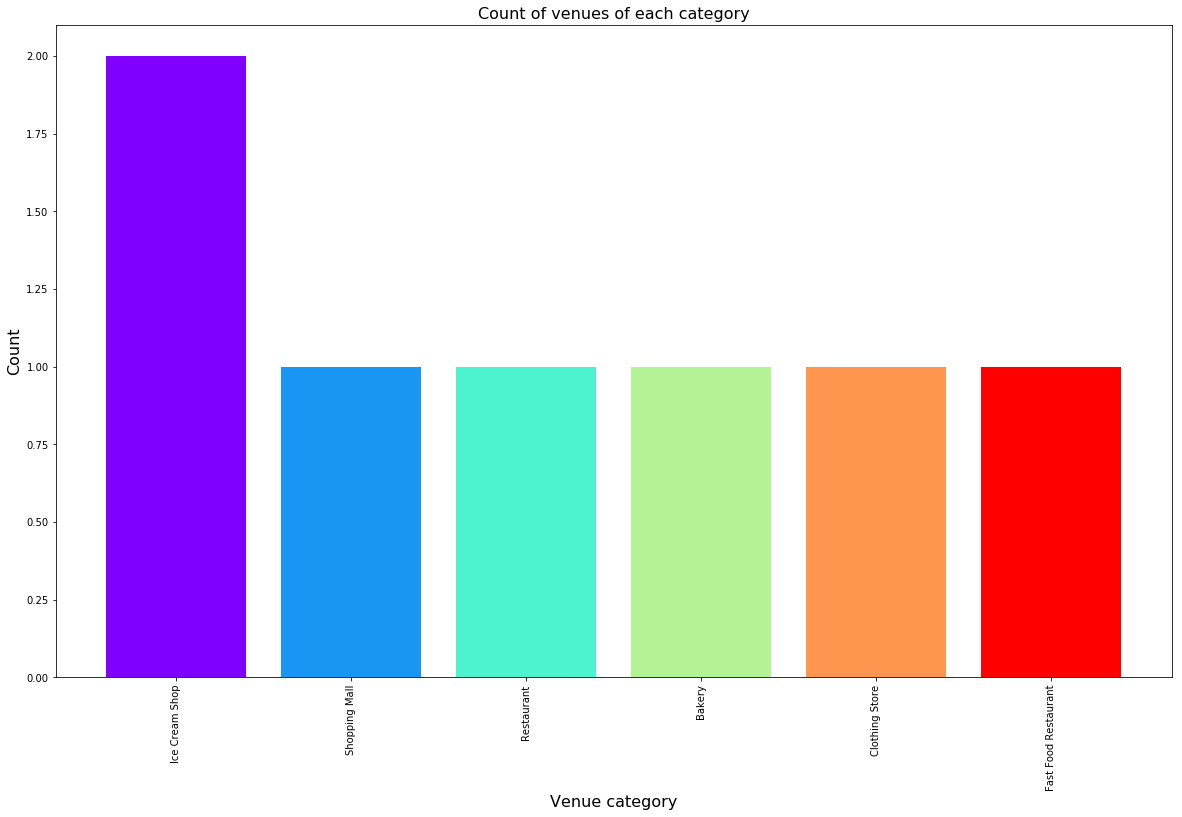

In [15]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

Rating of different places is an imp factor on which a person usually decides whether it is worth it to visit the place.We will first have to see what is the average rating for all the venues.We will next plot the venues on the map and color code them.
We will first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

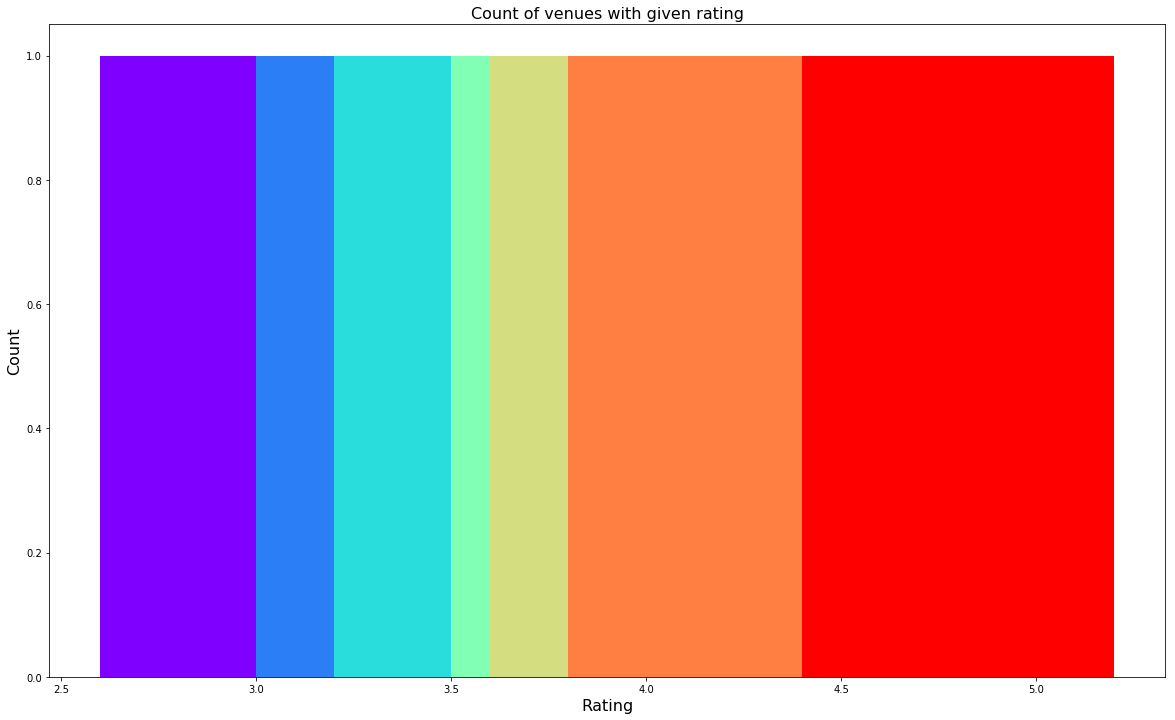

In [16]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

Let us now create bins for various ratings and plot them in different colors on the map. The ratings should be divided between 4 bins:
1 to 2
2 to 3
3 to 4
4 to 5

In [17]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [19]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}
vja_map = folium.Map(location = [VJA_LATITUDE,VJA_LONGITUDE], zoom_start = 13)
for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(vja_map)  
vja_map

We will now look at the venues based on the price values. We have two price features for our places,average_price which defines the average cost for one person
and price_range which determines the price range as defined by Zomato API.

In [22]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Text(0.5, 1.0, 'Count of venues with given average price')

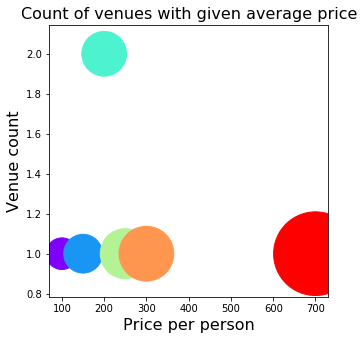

In [28]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (5, 5))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

## clustering

In [30]:
from sklearn.cluster import KMeans
NO_OF_CLUSTERS = 2
clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,0,Ice Cream Shop,Baskin Robbins,16.5033,80.6481,1,3.4,"40-5-19/2, Tille Road, Labbipet, Vijayawada",Good,100.0
1,0,Bakery,Kitkat,16.5008,80.6577,2,3.6,"K.P Nagar, Chandralok Complex, Beside TVS Show...",Good,200.0
2,1,Clothing Store,Barbeque Nation,16.5003,80.6458,3,4.8,"3rd Floor, LEPL Centro Mall, M.G.Road, Labbipe...",Very good,700.0
3,0,Shopping Mall,Keventers - The Original Milkshake,16.5024,80.6426,2,3.0,"39-1-57, Third Floor, PVP Square Mall, MG Road...",Okay,200.0
4,0,Fast Food Restaurant,Subway,16.5044,80.6471,2,4.0,"40-6-22/1A, Labbipet, Vijayawada",Good,250.0


In [31]:
vja_map = folium.Map(location = [VJA_LATITUDE, VJA_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(vja_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(vja_map)
vja_map

In [32]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,rating_bin,average_price
0,0,Ice Cream Shop,Baskin Robbins,16.5033,80.6481,1,3.4,"40-5-19/2, Tille Road, Labbipet, Vijayawada",Good,100.0
1,0,Bakery,Kitkat,16.5008,80.6577,2,3.6,"K.P Nagar, Chandralok Complex, Beside TVS Show...",Good,200.0
2,0,Shopping Mall,Keventers - The Original Milkshake,16.5024,80.6426,2,3.0,"39-1-57, Third Floor, PVP Square Mall, MG Road...",Okay,200.0
3,0,Fast Food Restaurant,Subway,16.5044,80.6471,2,4.0,"40-6-22/1A, Labbipet, Vijayawada",Good,250.0
4,0,Ice Cream Shop,Cream Stone,16.5039,80.6365,1,4.2,"Vijayawada, Punammathota, Labbipet, Vijayawada",Very good,150.0
5,0,Restaurant,Blue Fox,16.5022,80.6432,2,3.9,"Minerva Grand, Near PVP Square Mall, M.G Road,...",Good,300.0
